In [1]:
import re
import json
import matplotlib.pyplot as plt
import numpy as np

## eval finding min

### preprocessing

In [2]:
MAX_DIGITS = 5

In [3]:
with open('gemini_response/list_min_responses.txt','r') as file:
    responses = file.readlines()

# all responses are in the form of: Min([a,b,c,d,e])=x
# we will now extract list and min values
lists_responses_min = []
mins_responses = []

for response in responses:
    match = re.search(r'Min\((\[[^\]]+\])\) = ([+-]?\d+)',response)

    if match:
        lists_responses_min.append(json.loads(match.group(1)))
        mins_responses.append(int(match.group(2)))

In [4]:
assert len(lists_responses_min)==len(mins_responses)
print(f'Found {len(mins_responses)} responses')

Found 3021 responses


In [5]:
# check how many test examples were there
with open('../../data/lists.json','r') as file:
    input_data = json.load(file)
total_examples = 0
for type in input_data:
    total_examples += len(input_data[type])

print(f'Found {total_examples} examples')

Found 3000 examples


here, number of responses are more, hence we will have to check for duplicates and remove them

In [6]:
from collections import Counter
# read input examples
input_examples = []
for type in input_data:
    for example in input_data[type]:
        input_examples.append(example)

# convert into tuples
tuples_responses_min = [tuple(response) for response in lists_responses_min]
tuple_ip_examples = [tuple(example) for example in input_examples]

# check how many examples are there
response_counter = Counter(tuples_responses_min)
ip_example_counter = Counter(tuple_ip_examples)

# find where counts are different
diff = response_counter - ip_example_counter
print(f'Found {len(diff)} examples')

# print examples
for example in diff:
    print(f'{example}','repsonse count:',response_counter[example],'ip example count:',ip_example_counter[example])

Found 21 examples
(83, 52, 14, 17, 5, 4, 38, 63, 14, 12) repsonse count: 2 ip example count: 1
(52, 35, 4, 88, 47, 27, 56, 56, 30, 46) repsonse count: 2 ip example count: 1
(12, 87, 47, 69, 82, 45, 7, 50, 35, 24) repsonse count: 2 ip example count: 1
(15, 58, 11, 84, 27, 82, 81, 76, 2, 6) repsonse count: 2 ip example count: 1
(42, 31, 16, 72, 26, 8, 97, 70, 26, 75) repsonse count: 2 ip example count: 1
(27, 29, 42, 99, 18, 76, 0, 35, 18, 16) repsonse count: 2 ip example count: 1
(69, 32, 22, 14, 84, 3, 16, 1, 45, 30) repsonse count: 2 ip example count: 1
(75, 41, 2, 22, 33, 6, 16, 94, 53, 67) repsonse count: 2 ip example count: 1
(14, 95, 8, 60, 57, 99, 46, 65, 75, 13) repsonse count: 2 ip example count: 1
(57, 64, 28, 78, 5, 93, 84, 66, 38, 58) repsonse count: 2 ip example count: 1
(82, 3, 7, 61, 51, 54, 87, 13, 62, 91) repsonse count: 2 ip example count: 1
(56, 9, 10, 41, 77, 18, 8, 16, 35, 79) repsonse count: 2 ip example count: 1
(81, 74, 70, 91, 41, 48, 76, 67, 37, 58) repsonse co

In [7]:
# create new list of responses in which we remove the extra responses
new_list_responses_min = []
new_mins_responses = []

# add non-extra responses
for i,lst in enumerate(lists_responses_min):
    # if response count is greater than ip example count, decrement response count
    if response_counter[tuple(lst)] > ip_example_counter[tuple(lst)]:
        response_counter[tuple(lst)] -= 1
    # if response count is equal to ip example count, add to new list
    else:
        new_list_responses_min.append(lst)
        new_mins_responses.append(mins_responses[i])
    
print(f'New responses count: {len(new_list_responses_min)}')
print(f'New mins count: {len(new_mins_responses)}')

# check the counts again
for example in diff:
    print(f'{example}: ','repsonse count:',response_counter[example],'ip example count:',ip_example_counter[example])


lists_responses_min = new_list_responses_min
mins_responses = new_mins_responses

New responses count: 3000
New mins count: 3000
(83, 52, 14, 17, 5, 4, 38, 63, 14, 12):  repsonse count: 1 ip example count: 1
(52, 35, 4, 88, 47, 27, 56, 56, 30, 46):  repsonse count: 1 ip example count: 1
(12, 87, 47, 69, 82, 45, 7, 50, 35, 24):  repsonse count: 1 ip example count: 1
(15, 58, 11, 84, 27, 82, 81, 76, 2, 6):  repsonse count: 1 ip example count: 1
(42, 31, 16, 72, 26, 8, 97, 70, 26, 75):  repsonse count: 1 ip example count: 1
(27, 29, 42, 99, 18, 76, 0, 35, 18, 16):  repsonse count: 1 ip example count: 1
(69, 32, 22, 14, 84, 3, 16, 1, 45, 30):  repsonse count: 1 ip example count: 1
(75, 41, 2, 22, 33, 6, 16, 94, 53, 67):  repsonse count: 1 ip example count: 1
(14, 95, 8, 60, 57, 99, 46, 65, 75, 13):  repsonse count: 1 ip example count: 1
(57, 64, 28, 78, 5, 93, 84, 66, 38, 58):  repsonse count: 1 ip example count: 1
(82, 3, 7, 61, 51, 54, 87, 13, 62, 91):  repsonse count: 1 ip example count: 1
(56, 9, 10, 41, 77, 18, 8, 16, 35, 79):  repsonse count: 1 ip example count: 1

### evaluation

In [8]:
def num_digits(num):
    return len(str(num).replace('-',''))

def max_num_digit(lst):
    return max([num_digits(num) for num in lst])

In [9]:
# Total (sign(+,-),len(list),num_digits)
# signs = + or -, len(list) = 3,5,10
total_min = np.zeros((2,3,MAX_DIGITS))
correct_min = np.zeros((2,3,MAX_DIGITS))

len_mapping = {3:0,5:1,10:2}

for lst,ans in zip(lists_responses_min,mins_responses):
    # get sign
    sign = 1 if any(num<0 for num in lst) else 0  # 0 for +, 1 for -

    # get len of list and map it to 0,1,2
    len_ = len_mapping[len(lst)] # 0 for 3, 1 for 5, 2 for 10

    # get max number of digits of an element in the list
    num_digit = max_num_digit(lst)

    # update counts
    total_min[sign,len_,num_digit-1] += 1
    correct_min[sign,len_,num_digit-1] += (min(lst) == ans)

accuracy_min = correct_min*100/total_min

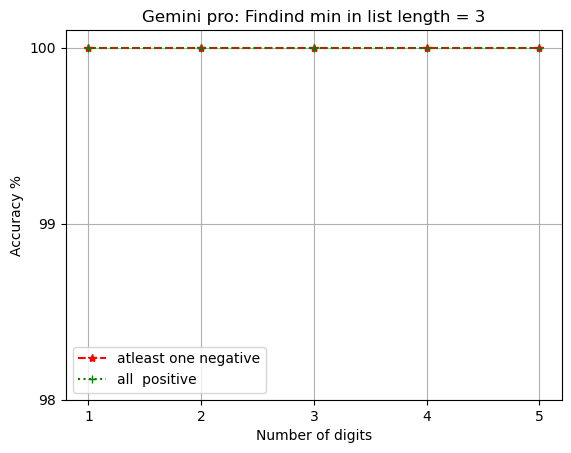

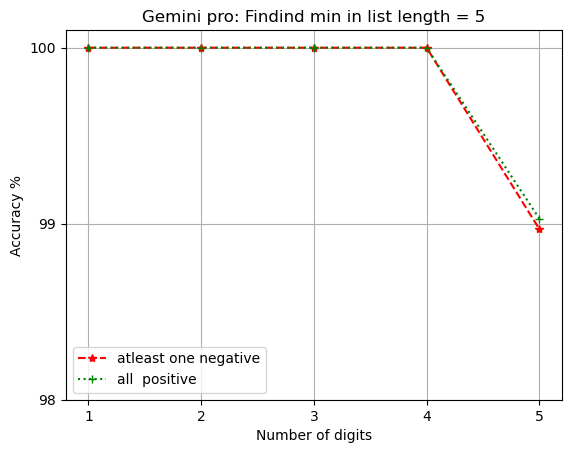

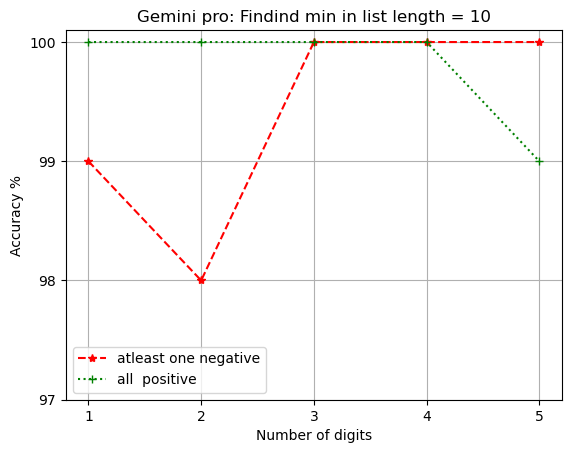

In [10]:
# 0 th index = sign , 0 for +, 1 for -
# 1st index = len of list, 0 for 3, 1 for 5, 2 for 10
# 2nd index = num of digits - 1

# for a list of length 3,
plt.plot(range(1,MAX_DIGITS+1),accuracy_min[1,0,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),accuracy_min[0,0,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.ylim(98,100.1)
plt.yticks(range(98,101,1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Findind min in list length = 3')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/List_min_accuracy_list_length_3.png')
plt.show()


# for a list of length 5,
plt.plot(range(1,MAX_DIGITS+1),accuracy_min[1,1,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),accuracy_min[0,1,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.ylim(98,100.1)
plt.yticks(range(98,101,1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Findind min in list length = 5')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/List_min_accuracy_list_length_5.png')
plt.show()

# for a list of length 10,
plt.plot(range(1,MAX_DIGITS+1),accuracy_min[1,2,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),accuracy_min[0,2,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.ylim(98,100.1)
plt.yticks(range(97,101,1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Findind min in list length = 10')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/List_min_accuracy_list_length_10.png')
plt.show()


## eval finding max

### preprocessing

In [11]:
MAX_DIGITS = 5

In [12]:
with open('gemini_response/list_max_responses.txt','r') as file:
    responses = file.readlines()

# all responses are in the form of: Max([a,b,c,d,e])=x
# we will now extract list and min values
lists_responses_max = []
max_responses = []

for response in responses:
    match = re.search(r'Max\((\[[^\]]+\])\) = ([+-]?\d+)',response)

    if match:
        lists_responses_max.append(json.loads(match.group(1)))
        max_responses.append(int(match.group(2)))

In [13]:
assert len(lists_responses_max)==len(max_responses)
print(f'Found {len(max_responses)} responses')

Found 3000 responses


No preprocessing required

### evaluation

In [14]:
def num_digits(num):
    return len(str(num).replace('-',''))

def max_num_digit(lst):
    return max([num_digits(num) for num in lst])

In [15]:
# Total (sign(+,-),len(list),num_digits)
# signs = + or -, len(list) = 3,5,10

total_max = np.zeros((2,3,MAX_DIGITS))
correct_max = np.zeros((2,3,MAX_DIGITS))

len_mapping = {3:0,5:1,10:2}

for lst,ans in zip(lists_responses_max,max_responses):

    # get sign
    sign = 1 if any(num<0 for num in lst) else 0  # 0 for +, 1 for -

    # get len of list and map it to 0,1,2
    len_ = len_mapping[len(lst)] # 0 for 3, 1 for 5, 2 for 10

    # get max number of digits of an element in the list
    num_digit = max_num_digit(lst)

    # update counts
    total_max[sign,len_,num_digit-1] += 1
    correct_max[sign,len_,num_digit-1] += (max(lst) == ans)

accuracy_max = correct_max*100/total_max

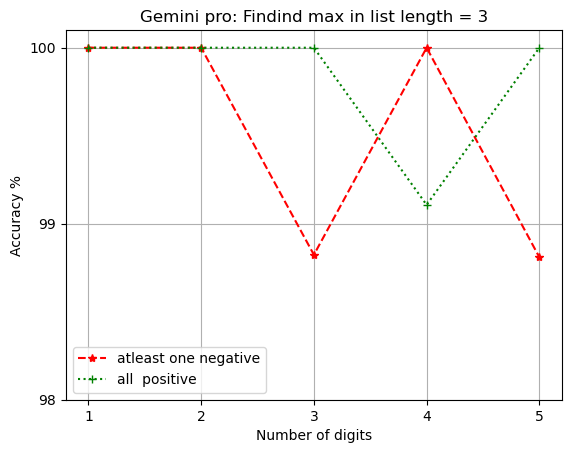

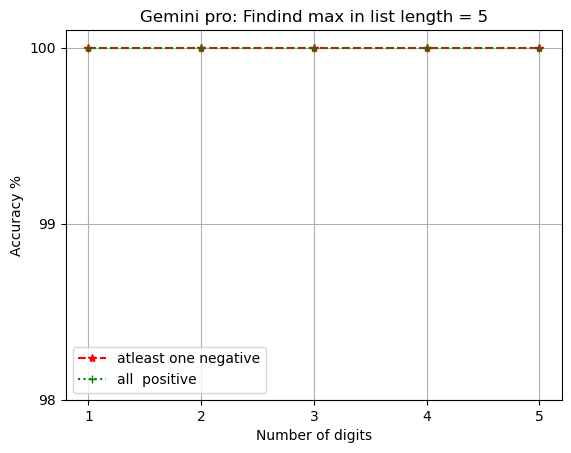

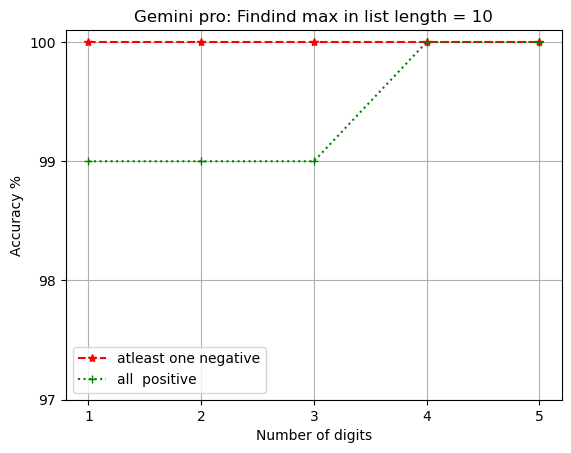

In [16]:
# 0 th index = sign , 0 for +, 1 for -
# 1st index = len of list, 0 for 3, 1 for 5, 2 for 10
# 2nd index = num of digits - 1

# for a list of length 3,
plt.plot(range(1,MAX_DIGITS+1),accuracy_max[1,0,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),accuracy_max[0,0,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.ylim(98,100.1)
plt.yticks(range(98,101,1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Findind max in list length = 3')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/List_max_accuracy_list_length_3.png')
plt.show()


# for a list of length 5,
plt.plot(range(1,MAX_DIGITS+1),accuracy_max[1,1,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),accuracy_max[0,1,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.ylim(98,100.1)
plt.yticks(range(98,101,1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Findind max in list length = 5')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/List_max_accuracy_list_length_5.png')
plt.show()

# for a list of length 10,
plt.plot(range(1,MAX_DIGITS+1),accuracy_max[1,2,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),accuracy_max[0,2,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.ylim(98,100.1)
plt.yticks(range(97,101,1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Findind max in list length = 10')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/List_max_accuracy_list_length_10.png')
plt.show()
